In [1]:
#Call required libraries
import time                   
import warnings               
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt                   
import seaborn as sns
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture 

#inputs
holiday_pd = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/Data_Workbook.xlsx', sheet_name = 'Holiday Dates')
lat_long_data = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/Data_Workbook.xlsx', sheet_name = 'City-Lat-Long')
county_load = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/Data_Workbook.xlsx', sheet_name = 'Load By County 2018')
county_gdp = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/Data_Workbook.xlsx', sheet_name = 'GDP By County 2018')
city_pop = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/Data_Workbook.xlsx', sheet_name = 'City Population')
caiso_2016 = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/CAISO Load.xlsx',sheet_name = '2016')
caiso_2017 = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/CAISO Load.xlsx',sheet_name = '2017')
caiso_2018 = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/CAISO Load.xlsx',sheet_name = '2018')
city_wx_data = pd.read_csv('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/all_wx_data.csv')

#select specific columns not all
city_wx_data = city_wx_data[['City', 'Year', 'Month', 'Day', 'Hour', 'Temperature',
       'Relative Humidity',
       'Cloud Type', 'Dew Point', 'Wind Speed']]
city_wx_data = city_wx_data.drop_duplicates()
caiso_total = caiso_2016.append([caiso_2017,caiso_2018])
caiso_total['Date'] = pd.to_datetime(caiso_total['Date'])
caiso_total['Month'] = caiso_total['Date'].dt.month
caiso_total['Day'] = caiso_total['Date'].dt.day
caiso_total['Year'] = caiso_total['Date'].dt.year
caiso_total['Day_of_week'] = caiso_total['Date'].dt.dayofweek
caiso_total['Week'] = caiso_total['Date'].dt.week
caiso_total = caiso_total.rename(columns={"HE": "Hour"})

#read-in
city_elec = pd.read_excel('C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/City_Electricity_Data_1.xlsx')
city_elec_complete = city_elec.dropna()
city_elec_complete = city_elec_complete.drop_duplicates()
city_elec_complete['total_elec_mwh'] = city_elec_complete['res_elec_mwh']+city_elec_complete['com_elec_mwh']+city_elec_complete['ind_elec_mwh']
city_elec_complete.sort_values(ascending = False,by = 'total_elec_mwh').head(10)
city_elec_complete= city_elec_complete[['City','housing_units', 'total_pop', 'res_elec_mwh', 'com_units',
       'com_elec_mwh', 'ind_units', 'ind_elec_mwh','total_elec_mwh']]
#city_elec_complete.sort_values(ascending = False,by = 'com_elec_mwh').head(10)
#gather top10 commercial,industrial,residential
top10_commercial = city_elec_complete.sort_values(ascending = False,by = 'com_elec_mwh').head(10)[['City', 'total_pop', 'com_elec_mwh']]
top10_commercial.columns = ['City', 'Total Population' ,'Commercial MWh Usage']
top10_industrial = city_elec_complete.sort_values(ascending = False,by = 'ind_elec_mwh').head(10)[['City', 'total_pop', 'ind_elec_mwh']]
top10_industrial.columns = ['City', 'Total Population' ,'Industrial MWh Usage']
top10_residential = city_elec_complete.sort_values(ascending = False,by = 'res_elec_mwh').head(10)[['City', 'total_pop', 'res_elec_mwh']]
top10_residential.columns = ['City', 'Total Population' ,'Residential MWh Usage']
top10_consumption = city_elec_complete.sort_values(ascending = False,by = 'total_elec_mwh').head(10)[['City', 'total_pop', 'total_elec_mwh']]
top10_consumption.columns = ['City', 'Total Population' ,'Total MWh Usage']             
#create percentages
city_elec_complete['ind_pct'] = city_elec_complete['ind_elec_mwh']/city_elec_complete['total_elec_mwh']
city_elec_complete['res_pct'] = city_elec_complete['res_elec_mwh']/city_elec_complete['total_elec_mwh']
city_elec_complete['com_pct'] = city_elec_complete['com_elec_mwh']/city_elec_complete['total_elec_mwh']
#correlation charts
correlations_2 = city_elec_complete[['total_pop','res_pct', 'com_pct', 'ind_pct']].corr()
correlations_1 = city_elec_complete[['total_pop','res_elec_mwh','com_elec_mwh','ind_elec_mwh']].corr()

In [2]:
#Time series clustering
from tslearn.clustering import TimeSeriesKMeans
import warnings
warnings.filterwarnings('ignore')

#Scale the data as the data is in different units
city_wx_cluster = city_wx_data[['City', 'Temperature',
       'Relative Humidity',
       'Cloud Type', 'Dew Point', 'Wind Speed']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

req_cols = ['Temperature',
       'Relative Humidity',
       'Cloud Type', 'Dew Point', 'Wind Speed']

#scale for clustering
city_wx_cluster_scaled = scaler.fit_transform(city_wx_cluster[req_cols])
city_wx_cluster_scaled_df = pd.DataFrame(city_wx_cluster_scaled)

#Add back the city column
city_wx_cluster_scaled_df['City'] = city_wx_cluster['City']

list_of_cities = list(set(city_wx_cluster.City.values))
#np.array(city_wx_cluster_scaled_df[city_wx_cluster_scaled_df.City == list_of_cities[0]].iloc[:,0:5])
wx_cluster = []

for i in range(0,len(list_of_cities)):
    wx_cluster.append(np.array(city_wx_cluster_scaled_df[city_wx_cluster_scaled_df.City == list_of_cities[i]].iloc[:,0:5]))


#Assign Labels
city_wx_cluster = pd.DataFrame(list_of_cities)
ts_kmeans_optimal = TimeSeriesKMeans(n_clusters = 5, metric="euclidean", max_iter = 3, max_iter_barycenter=3, random_state = 5).fit(wx_cluster)
wx_cluster_label = list(ts_kmeans_optimal.labels_)
city_wx_cluster['Weather Cluster'] = wx_cluster_label
city_wx_cluster.columns = ['City', 'Weather Cluster']

#get all stats
wx_cluster_0 = city_wx_cluster[city_wx_cluster['Weather Cluster'] == 0].merge(city_elec_complete,on='City')
wx_cluster_1 = city_wx_cluster[city_wx_cluster['Weather Cluster'] == 1].merge(city_elec_complete,on='City')
wx_cluster_2 = city_wx_cluster[city_wx_cluster['Weather Cluster'] == 2].merge(city_elec_complete,on='City')
wx_cluster_3 = city_wx_cluster[city_wx_cluster['Weather Cluster'] == 3].merge(city_elec_complete,on='City')
wx_cluster_4 = city_wx_cluster[city_wx_cluster['Weather Cluster'] == 4].merge(city_elec_complete,on='City')

C:\Users\zohai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#create elbow function plot
def plot_elbow_method(cluster_df):
    wcss = []
    for i in range(1,5):
        kmeans = KMeans(n_clusters = i, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 5)
        kmeans.fit(cluster_df)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1,5),wcss)
    plt.title('Optimal K/Elbow method visualization')
    plt.ylabel('Within Cluster Sum-of-Squares')
    plt.xlabel('Number of Clusters/K')
    plt.show()
    
req_columns = ['res_pct', 'com_pct', 'ind_pct']

#create kmeans labels
def get_kmeans_labels(cluster_df):
    kmeans = KMeans(n_clusters = 2, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 5).fit(cluster_df)
    labels = list(kmeans.labels_)
    return labels

#create centroid 
def get_closest_to_centroid(cluster_df):
    from sklearn.metrics import pairwise_distances_argmin_min
    kmeans = KMeans(n_clusters = 2, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 5).fit(cluster_df)
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, cluster_df)
    return closest

cluster_0_sub = wx_cluster_0[req_columns]
cluster_1_sub = wx_cluster_1[req_columns]
cluster_2_sub = wx_cluster_2[req_columns]
cluster_3_sub = wx_cluster_3[req_columns]
cluster_4_sub = wx_cluster_4[req_columns]

#scaling for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cluster_0_sub_scaled = scaler.fit_transform(cluster_0_sub)
cluster_1_sub_scaled = scaler.fit_transform(cluster_1_sub)
cluster_2_sub_scaled = scaler.fit_transform(cluster_2_sub)
cluster_3_sub_scaled = scaler.fit_transform(cluster_3_sub)
cluster_4_sub_scaled = scaler.fit_transform(cluster_4_sub)

In [5]:
wx_cluster_0['Electric Sub-Cluster'] = get_kmeans_labels(wx_cluster_0[req_columns])
wx_cluster_1['Electric Sub-Cluster'] = get_kmeans_labels(wx_cluster_1[req_columns])
wx_cluster_2['Electric Sub-Cluster'] = get_kmeans_labels(wx_cluster_2[req_columns])
wx_cluster_3['Electric Sub-Cluster'] = get_kmeans_labels(wx_cluster_3[req_columns])
wx_cluster_4['Electric Sub-Cluster'] = get_kmeans_labels(wx_cluster_4[req_columns])

ex_wx_cluster_0 = wx_cluster_0[['City', 'Weather Cluster', 'Electric Sub-Cluster','ind_pct', 'res_pct', 'com_pct', 'total_pop' , 'total_elec_mwh']]
ex_wx_cluster_1 = wx_cluster_1[['City', 'Weather Cluster', 'Electric Sub-Cluster','ind_pct', 'res_pct', 'com_pct', 'total_pop' , 'total_elec_mwh']]
ex_wx_cluster_2 = wx_cluster_2[['City', 'Weather Cluster', 'Electric Sub-Cluster','ind_pct', 'res_pct', 'com_pct', 'total_pop' , 'total_elec_mwh']]
ex_wx_cluster_3 = wx_cluster_3[['City', 'Weather Cluster', 'Electric Sub-Cluster','ind_pct', 'res_pct', 'com_pct', 'total_pop' , 'total_elec_mwh']]
ex_wx_cluster_4 = wx_cluster_4[['City', 'Weather Cluster', 'Electric Sub-Cluster','ind_pct', 'res_pct', 'com_pct', 'total_pop' , 'total_elec_mwh']]

all_ex_wx_cluster = ex_wx_cluster_0.append([ex_wx_cluster_1, ex_wx_cluster_2, ex_wx_cluster_3,ex_wx_cluster_4])
#arcgis data
arcgis_data_all = all_ex_wx_cluster[['City', 'Weather Cluster', 'Electric Sub-Cluster', 'total_pop' , 'total_elec_mwh']]

In [38]:
wx00_max_load = wx_cluster_0[wx_cluster_0['Electric Sub-Cluster'] == 0]['total_elec_mwh'].max()
wx01_max_load = wx_cluster_0[wx_cluster_0['Electric Sub-Cluster'] == 1]['total_elec_mwh'].max()
wx10_max_load = wx_cluster_1[wx_cluster_1['Electric Sub-Cluster'] == 0]['total_elec_mwh'].max()
wx11_max_load = wx_cluster_1[wx_cluster_1['Electric Sub-Cluster'] == 1]['total_elec_mwh'].max()
wx20_max_load = wx_cluster_2[wx_cluster_2['Electric Sub-Cluster'] == 0]['total_elec_mwh'].max()
wx21_max_load = wx_cluster_2[wx_cluster_2['Electric Sub-Cluster'] == 1]['total_elec_mwh'].max()
wx30_max_load = wx_cluster_3[wx_cluster_3['Electric Sub-Cluster'] == 0]['total_elec_mwh'].max()
wx31_max_load = wx_cluster_3[wx_cluster_3['Electric Sub-Cluster'] == 1]['total_elec_mwh'].max()
wx40_max_load = wx_cluster_4[wx_cluster_4['Electric Sub-Cluster'] == 0]['total_elec_mwh'].max()
wx41_max_load = wx_cluster_4[wx_cluster_4['Electric Sub-Cluster'] == 1]['total_elec_mwh'].max()

#Cities List based on max load in each subcluster
city_1=wx_cluster_0[wx_cluster_0['total_elec_mwh'] == wx00_max_load]['City'].item()
city_2=wx_cluster_0[wx_cluster_0['total_elec_mwh'] == wx01_max_load]['City'].item()
city_3=wx_cluster_1[wx_cluster_1['total_elec_mwh'] == wx10_max_load]['City'].item()
city_4=wx_cluster_1[wx_cluster_1['total_elec_mwh'] == wx11_max_load]['City'].item()
city_5=wx_cluster_2[wx_cluster_2['total_elec_mwh'] == wx20_max_load]['City'].item()
city_6=wx_cluster_2[wx_cluster_2['total_elec_mwh'] == wx21_max_load]['City'].item()
city_7=wx_cluster_3[wx_cluster_3['total_elec_mwh'] == wx30_max_load]['City'].item()
city_8=wx_cluster_3[wx_cluster_3['total_elec_mwh'] == wx31_max_load]['City'].item()
city_9=wx_cluster_4[wx_cluster_4['total_elec_mwh'] == wx40_max_load]['City'].item()
city_10=wx_cluster_4[wx_cluster_4['total_elec_mwh'] == wx41_max_load]['City'].item()

cities_list = ['Petaluma' , 'San Francisco', 'Sacramento', 'San Jose', 'Los Angeles', 'San Diego', 'Roseville', 'Chico', 'Fresno', 'Lemoore']
cities_list_df = pd.DataFrame(cities_list)
cities_list_df.columns = ['City']


In [40]:
# tuned tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

parameters = {'max_leaf_nodes': randint(3, 200),
              'max_features': randint(2, 76),
              'max_depth': randint(1, 10)}
rnd_params = RandomizedSearchCV(tree, param_distributions = parameters, cv = 10, n_iter = 200)
rnd_params.fit(final_data_X_train, final_data_Y_train)

best_parameters = rnd_params.best_params_
print(best_parameters)

tree.set_params(max_features=best_parameters['max_features'], max_leaf_nodes=best_parameters['max_leaf_nodes'])
tree.fit(final_data_X_train, final_data_Y_train)

tuned_train_score = tree.score(final_data_X_train, final_data_Y_train)
tuned_test_score = tree.score(final_data_X_test, final_data_Y_test)
y_pred_tuned_tree = tree.predict(final_data_X_test)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor

rf_tree = RandomForestRegressor()
rf_tree.fit(final_data_X_train, final_data_Y_train)

param_dist = {'n_estimators': randint(10, 100),
               'max_leaf_nodes': randint(3, 100),
               'max_features': ["auto"],
               'max_depth': randint(1, 10),
               'min_samples_leaf': randint(1, 30),
               'min_samples_split': randint(2, 20)}

rnd_search_rf = RandomizedSearchCV(rf_tree, param_distributions=param_dist, 
                                 cv=10, n_iter=50)
rnd_search_rf.fit(final_data_X_train, final_data_Y_train)

rf_tree.set_params(n_estimators=rnd_search_rf.best_params_['n_estimators'], 
                     max_leaf_nodes=rnd_search_rf.best_params_['max_leaf_nodes'], 
                     max_features = rnd_search_rf.best_params_['max_features'],
                     max_depth = rnd_search_rf.best_params_['max_depth'],
                     min_samples_leaf = rnd_search_rf.best_params_['min_samples_leaf'],
                     min_samples_split = rnd_search_rf.best_params_['min_samples_split'])


#Tuned SVR
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVR
svr_regressor = SVR()
svr_regressor.fit(StandardScaler().fit_transform(final_data_X_train), final_data_Y_train) 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear','rbf']}  
  
svr_regressor_1 = RandomizedSearchCV(SVR(), param_distributions = param_grid) 
  
# fitting the model for grid search 
svr_regressor_1.fit(StandardScaler().fit_transform(final_data_X_train), final_data_Y_train) 
y_pred_svr = svr_regressor_1.predict(StandardScaler().fit_transform(final_data_X_test))

{'max_depth': 7, 'max_features': 50, 'max_leaf_nodes': 192}
0.9542729942738374
0.7294860967589885


In [43]:
results_df = final_data[final_data.Year == 2018]
results_df = results_df[['Day', 'Month','Hour', 'Year', 'CAISO Total']]
results_df['RF_Tuned_Prediction'] = rf_tree.predict(final_data_X_test)
results_df['SVR_Prediction'] = y_pred_svr
results_df['DTree_Tuned_Prediction'] = y_pred_tuned_tree

results_df['Hourly_MAPE_RF_Tuned'] = abs((results_df['CAISO Total'] - results_df['RF_Tuned_Prediction'])/results_df['CAISO Total'])*100
results_df['Hourly_MAPE_SVR'] = abs((results_df['CAISO Total'] - results_df['SVR_Prediction'])/results_df['CAISO Total'])*100
results_df['Hourly_MAPE_DTree_Tuned'] = abs((results_df['CAISO Total'] - results_df['DTree_Tuned_Prediction'])/results_df['CAISO Total'])*100
results_df

#mape functions

def get_month_count(df):
  month = [0]*12   
  for i in range(0, len(df)):
    if df['Month'].iloc[i] == 1:
        month[0] += 1
    elif df['Month'].iloc[i] == 2:
        month[1] += 1
    elif df['Month'].iloc[i] == 3:
        month[2] += 1
    elif df['Month'].iloc[i] == 4:
        month[3] += 1
    elif df['Month'].iloc[i] == 5:
        month[4] += 1
    elif df['Month'].iloc[i] == 6:
        month[5] += 1
    elif df['Month'].iloc[i] == 7:
        month[6] += 1
    elif df['Month'].iloc[i] == 8:
       month[7] += 1
    elif df['Month'].iloc[i] == 9:
        month[8] += 1
    elif df['Month'].iloc[i] == 10:
        month[9] += 1
    elif df['Month'].iloc[i] == 11:
        month[10] += 1
    elif df['Month'].iloc[i] == 12:
        month[11] += 1
  return month

d = get_month_count(results_df)
print(d)

def get_mape_by_month(df, column_name):

  final = df.pivot_table(column_name, index = 'Month', aggfunc='sum')
  return final 

import pandas as pd 

def get_mape_by_month(df, column_name):
  final = df.pivot_table(column_name, index = 'Month', aggfunc='sum')
  return final 

def mean(dataframe, d):
  for i in range(0, len(dataframe)):
    dataframe.iloc[i] = dataframe.iloc[i] / d[i]
  
  return dataframe


def create_mape_table(df, d):
  final_frame = pd.DataFrame()
  columns = list(df.columns[8:len(df.columns)])
  for i, val in enumerate(columns): 
    temp = get_mape_by_month(df,val)
    temp_frame = mean(temp, d)
    final_frame = pd.concat([final_frame, temp_frame], axis = 1)
  return final_frame 

final_frame = create_mape_table(results_df, d)
final_frame = final_frame.reset_index(drop = True)

[744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 720]


In [46]:
# Random Forest tree importances
pd.DataFrame({'Feature':final_data_X_train.columns, 'Importance': rf_tree.feature_importances_}).sort_values(by = 'Importance', ascending = False).reset_index(drop=True)

,Feature,Importance
0,fresno_relative_humidity,0.373411
1,Hour,0.255585
2,lemoore_temperature,0.111071
3,fresno_temperature,0.063811
4,Day_of_week,0.059408
5,lemoore_relative_humidity,0.021034
6,chico_relative_humidity,0.015598
7,Week,0.012467
8,Day,0.011358
9,chico_temperature,0.006728


In [47]:
#Decision tree importances
pd.DataFrame({'Feature':final_data_X_train.columns, 'Importance': tree.feature_importances_}).sort_values(by = 'Importance', ascending = False).reset_index(drop=True)

,Feature,Importance
0,fresno_relative_humidity,0.481964
1,Hour,0.267807
2,Day_of_week,0.062052
3,fresno_temperature,0.055203
4,lemoore_temperature,0.050826
5,lemoore_relative_humidity,0.017357
6,Day,0.011032
7,Week,0.007940
8,san_diego_dew_point,0.007538
9,los_angeles_temperature,0.004585


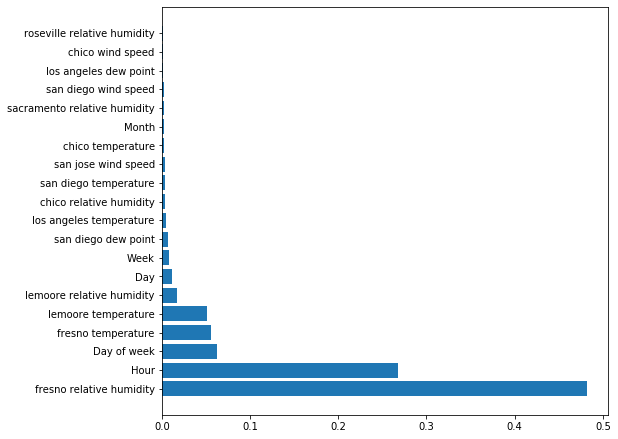

In [64]:
#Decision tree importances
feature_importance = tree.feature_importances_
mod_cols_x = [sub.replace('_', ' ') for sub in final_data_X_train.columns]

gb_feat = pd.DataFrame({'feature':mod_cols_x, 'importance':feature_importance})
gb_feat = gb_feat.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(8, 7.5))
plt.barh(width=gb_feat.importance, y=gb_feat.feature);

In [21]:
#Random forest importances

importances = rf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

indices

#Print the feature ranking
print("Feature ranking:")

for f in range(0,11):
    print("%d. %s (%f)" % (f, final_data_X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,11), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.show()

array([ 5,  3,  4, 54, 10,  9, 55,  2, 45, 24, 29, 19, 43,  1,  8, 32, 13,
       38, 44, 40, 14, 22, 30, 17, 25, 42, 50, 18, 35, 33, 48, 23, 28, 39,
       12,  7, 47, 52, 20, 15, 27, 37, 49, 34, 46, 11, 53, 36, 21, 16,  6,
       51, 41, 31, 26,  0], dtype=int64)

In [52]:
gb_feat = gb_feat.sort_values(by='importance', ascending= False).head(20)

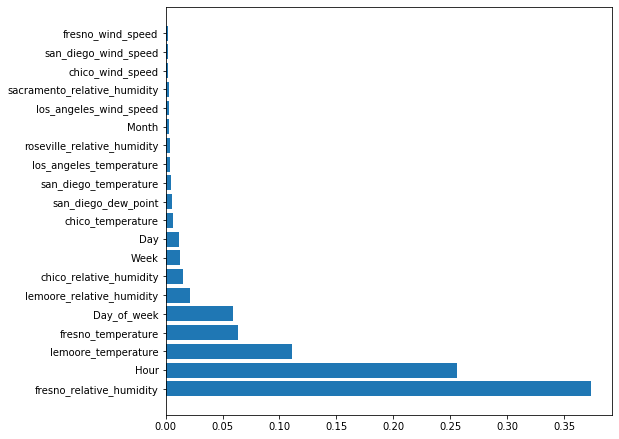

In [53]:
plt.figure(figsize=(8, 7.5))
plt.barh(width=gb_feat.importance, y=gb_feat.feature);

In [34]:
gb_feat['feature'] = df['B'].str.slice_replace(1, 3, 'AAA')

,feature,importance
5,fresno_relative_humidity,0.449245
3,Hour,0.260940
4,fresno_temperature,0.097121
54,Day_of_week,0.059365
10,chico_relative_humidity,0.017765
9,chico_temperature,0.017347
55,Week,0.012169
2,Day,0.011900
45,redding_relative_humidity,0.006338
24,ontario_temperature,0.004155


Feature ranking:
0. fresno_relative_humidity (0.373411)
1. Hour (0.255585)
2. lemoore_temperature (0.111071)
3. fresno_temperature (0.063811)
4. Day_of_week (0.059408)
5. lemoore_relative_humidity (0.021034)
6. chico_relative_humidity (0.015598)
7. Week (0.012467)
8. Day (0.011358)
9. chico_temperature (0.006728)
10. san_diego_dew_point (0.005414)
11. san_diego_temperature (0.005129)
12. los_angeles_temperature (0.003860)
13. roseville_relative_humidity (0.003626)
14. Month (0.003414)
15. los_angeles_wind_speed (0.003391)
16. sacramento_relative_humidity (0.003040)
17. chico_wind_speed (0.002434)
18. san_diego_wind_speed (0.002428)
19. fresno_wind_speed (0.002338)
20. los_angeles_dew_point (0.002248)
21. roseville_temperature (0.002050)
22. san_diego_relative_humidity (0.001976)
23. san_jose_wind_speed (0.001913)
24. los_angeles_relative_humidity (0.001855)
25. lemoore_wind_speed (0.001718)
26. sacramento_temperature (0.001360)
27. petaluma_relative_humidity (0.001332)
28. san_jose_rel

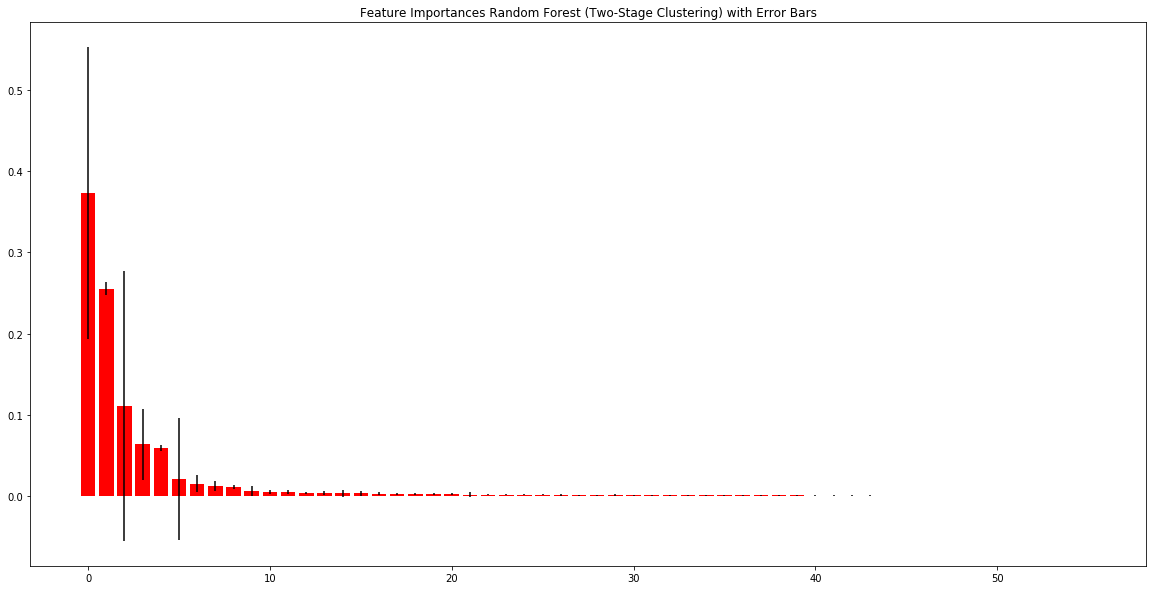

In [82]:
#Random Forest Importances
importances = rf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(final_data_X_train.shape[1]):
    print("%d. %s (%f)" % (f, final_data_X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances Random Forest (Two-Stage Clustering) with Error Bars")
plt.bar(range(final_data_X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.rcParams['figure.figsize'] = [20, 10]
plt.savefig("C:/Users/zohai/OneDrive/桌面/Comp 152/Final Project Material/Code/Data Folder/features_importances.png")